###  **Compute the total power and the PSD of noise signal**

Some defintions

1) **Power spectral density (PSD)** is a measure of power per unit frequency, with units in rad^2/Hz or V^2/Hz for phase and amplitude noise respectively. 


2) The **total noise power, P,** is the integrated noise over the whole spectrum. E.g. If we have white noise of PSD α over a frequency band from 0 to 43 kHZ (the SPS revolution frequency). The total noise power would be α*43e3. For a statistical process the total noise power equals the variance (σ^2).


- In our example the noise signal is a sequence of the noise kicks over turns.
- Thererfore, it is a discrete signal over time, $y_n$.
- The signal sampled at discrete times $y_n=y(n \Delta t)$ for a total measurement period of $T=N\Delta t$.
- $1 \leq n \leq N$. In other words N is the length of our signal.

The total noise power is given by:

\begin{equation}
P = \frac{\Delta t}{T} \sum_{n=0}^{N-1} \mid y_n \mid ^2 = \frac{1}{N^2} \sum_{n=0}^{N-1} \mid Y_k \mid ^2 
\end{equation}

where $Y_k$ is the discrete Fourier transform of $y_n$. Note that the two terms are equal as a result of the Parseval's theorem.

Note that in the expressions above the transform $Y_k$ is not in unitary form i.e. not normalised with $1 / \sqrt{N}$. Specifically:

\begin{equation}
Y_k = \sum_{n=0}^{N-1} y_n e^{-\frac{i 2\pi}{N} kn}
\end{equation}

which is also the result of the **numpy.fft.fft** function.


The PSD is given by:

\begin{equation}
S_{xx} = \frac{\mid Y_k \mid ^2 }{\Delta f N^2} 
\end{equation}

where $\Delta f$ is the sampling frequency.

**Note:** To obtain representative values of the power spectral density one should use the average of 1000 or more $\mid Y_k \mid ^2$.

In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [17]:
params = {'legend.fontsize': 20,
          'figure.figsize': (9, 7),
          'axes.labelsize': 27,
          'axes.titlesize': 23,
          'xtick.labelsize': 27,
          'ytick.labelsize': 27,
          'image.cmap': 'jet',
          'lines.linewidth': 3,
          'lines.markersize': 15,
          'font.family': 'sans-serif',
          'figure.autolayout': True}

plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rcParams.update(params)

#### Function for creating the noise signal

In [3]:
def create_colored_noise(N, std):        
    phi_0 = 1e-8  # amplitude of noise, aka stdPhaseNoise 
    Delta_psi = 0.18 # the peak of the spectrum

    psi_t_list = []
    psi_t = 0

    # parameters for ksi
    mean = 0.0
    std = std
    for i in range(N):
        psi_t_list.append(psi_t)
        ksi = np.random.normal(mean, std)  # different seed on each turn
        psi_t = psi_t + 2 * np.pi * Delta_psi + 2 * np.pi * ksi

    # Construct the noise signal
    y = phi_0 * np.cos(psi_t_list)
        
    return y

In [4]:
def compute_total_power(N, frev, std):
    time = np.arange(N)/frev # convert from turns to time
    Dt = time[1]-time[0] # sampling (s)
    freq = np.linspace(0, N/time[-1], N)
    Df = freq[1]-freq[0]
    
    
    y_noise = create_colored_noise(N, std)
    fft = np.fft.fft(y_noise)
    
    
    # the two methods should give the same due to the Parsheval's theorem
    total_power = np.sum(y_noise**2)*Dt/time[-1] # rad^2 or V^2 for phase and amplitude noise respectively
    total_power_fft = np.sum(np.abs(fft)**2)/N**2 # rad^2 or V^2
    var = np.var(y_noise) # it should be equal to the total power
    
    return total_power, total_power_fft, var

In [5]:
def compute_PSD(N, frev, std):
    time = np.arange(N)/frev # convert from turns to time
    Dt = time[1]-time[0] # sampling (s)
    freq = np.linspace(0, N/time[-1], N)
    Df = freq[1]-freq[0]
    
    #### To obtain a more precise value of PSD, we use the average of 10000 FFTs
    fft_list = []
    for i in range(1000):
        y_noise = create_colored_noise(N, std)
        fft = np.fft.fft(y_noise)
        fft_list.append(fft)
        
    mean_dft = np.mean(np.abs(fft_list)**2, axis=0)
    PSD = mean_dft/(Df*N**2) # power spectral density
    
    
    # compute the PSD at the frequency of interest. 
    # In our case in the betatron frequency, vb. 
    # find the closest value to the vb at the frequency list
    vb = 0.18
    closest_to_vb = freq[min(range(len(freq)), key=lambda i: abs(freq[i] - vb*frev))] # Hz
    PSD_vb_index = [i for i in range(len(freq)) if freq[i] == closest_to_vb]
    PSD_vb = PSD[PSD_vb_index][0] # rad^2/Hz or V^2/Hz
    
    
    return PSD, freq, PSD_vb

#### Define sampling parameters

In [6]:
N = 1000 # length of the signal
frev = 43.45e3 # the revolution frequency of SPS
std_list = [0.04, 0.06, 0.08, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0] # list of rms_ksi/2π

In [7]:
total_power_list = []
PSD_vb_list = []
for std in std_list:
    P1, P2, var = compute_total_power(N, frev, std)
    PSD, freq, PSD_vb = compute_PSD(N, frev, std)
    
    total_power_list.append(var)
    PSD_vb_list.append(PSD_vb)  

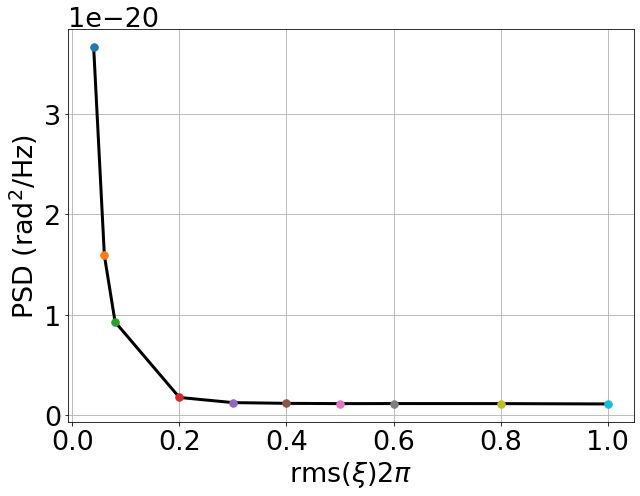

In [18]:
plt.plot(std_list, PSD_vb_list, c='k')
for index, std in enumerate(std_list):
    plt.plot(std, PSD_vb_list[index], '.')
plt.xlabel('rms('+r'$\xi$'+')'+r'$2 \pi$')
plt.ylabel('PSD (rad'+r'$^2$'+'/Hz)')
plt.grid()
#plt.savefig('PSD_vs_rmsKsi.png')